In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("..")

In [8]:
import sh_utilities
import utilities
from pathlib import Path
import imageio.v3 as im
import cv2
import matplotlib.pyplot as plt

Reading image...
Running spherical harmonics...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-229.25507..1830.5945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-228.95229..1829.5245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-226.0694..1818.9377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-200.32626..1723.0919].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-80.9013..1224.3652].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-74.18482..1178.6104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39.011127..9

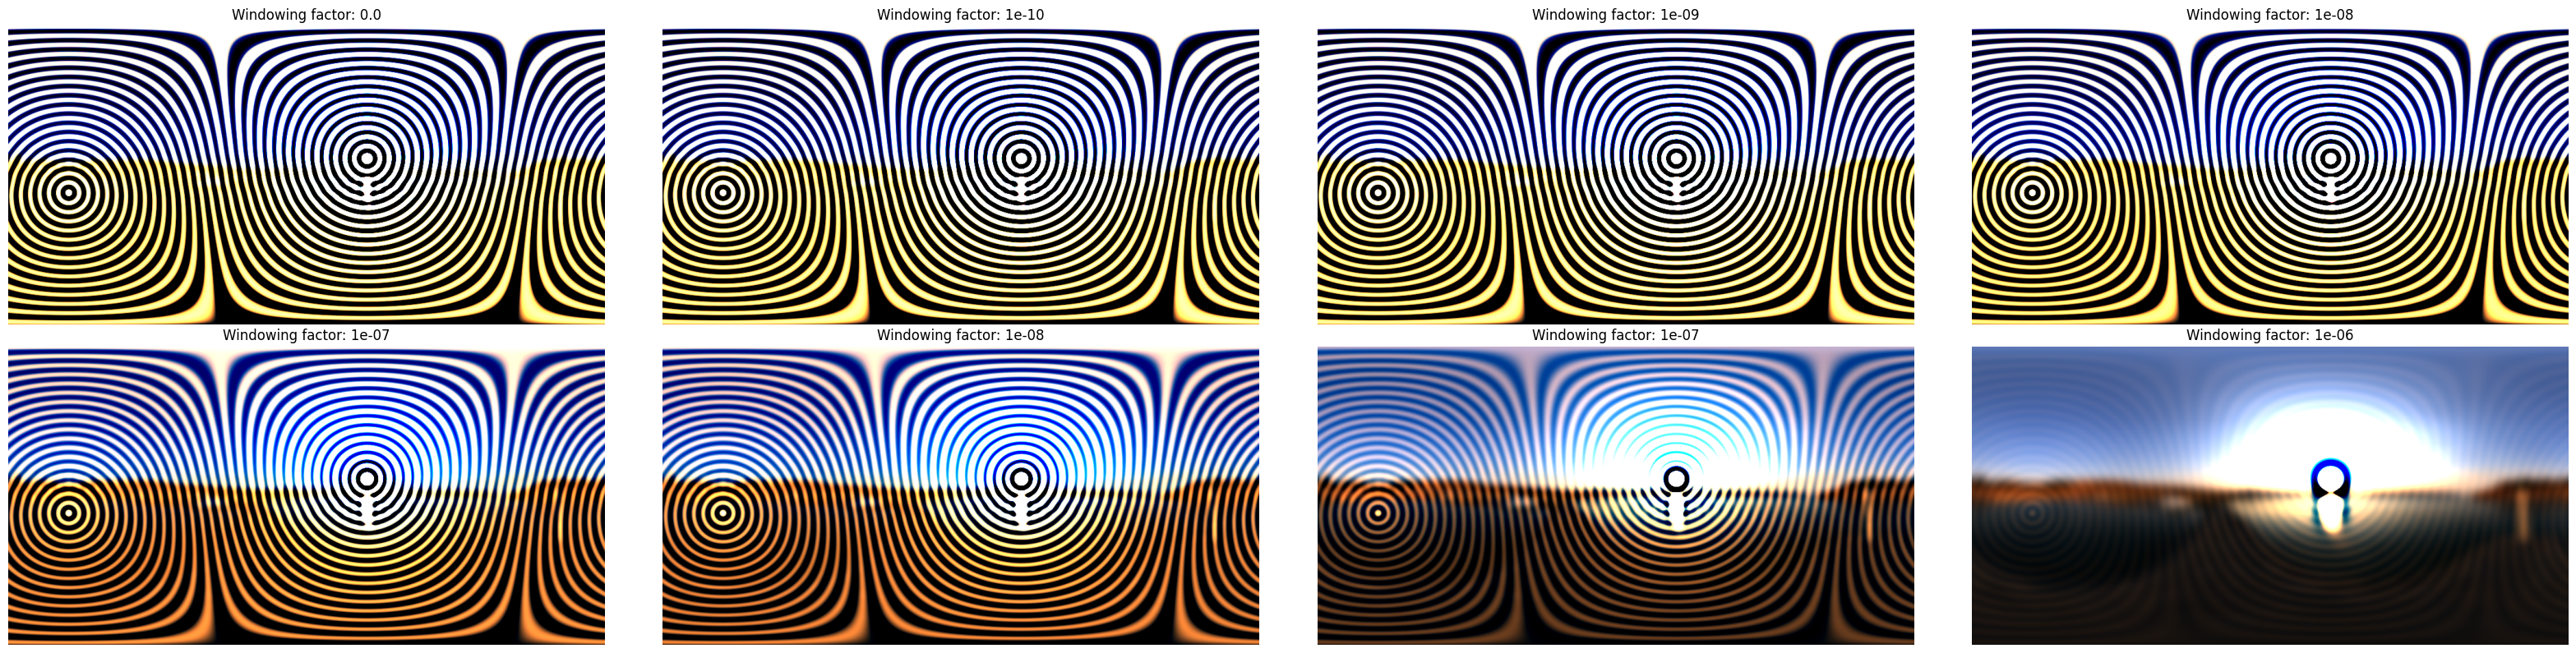

In [ ]:
l_max = 64
width = 1000
apply_window = 0.0

window_values = [0.0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-8, 1e-7, 1e-6]

filename = "../images/small_harbour_sunset_4k.hdr"

print("Reading image...")
plugin = "EXR-FI" if Path(filename).suffix == ".exr" else "HDR-FI"
height = width // 2
radiance_map_data = utilities.resize_image(
    im.imread(filename, plugin=plugin)[:, :, :3],
    width,
    height,
    cv2.INTER_CUBIC,
)


# SPH projection
print("Running spherical harmonics...")
# ibl_coeffs = sh_utilities.get_coefficients_from_file(args.ibl_filename, args.l_max, resize_width=args.resize_width)
ibl_coeffs_original = sh_utilities.get_coefficients_from_image(
    radiance_map_data, l_max, resize_width=width
)


cols = 4
rows = len(window_values) // cols + (len(window_values) % cols > 0)
fig, ax = plt.subplots(rows, cols, figsize=(4 * cols * 2, 4 * rows))
windowed_coeffs = []

Path("./output_windows").mkdir(exist_ok=True)
for i, windowing_factor in enumerate(window_values):
    ibl_coeffs = sh_utilities.apply_windowing(
        ibl_coeffs_original, windowing_factor=windowing_factor
    )
    windowed_coeffs.append(ibl_coeffs)
    reconstructed_signal = sh_utilities.sh_reconstruct_signal(
        ibl_coeffs, width=width
    )
    ax[i // cols, i % cols].imshow(reconstructed_signal)
    ax[i // cols, i % cols].set_title(f"Windowing factor: {windowing_factor}")
    ax[i // cols, i % cols].axis("off")
    im.imwrite(
        f"output_windows/sh_light_l{l_max}_{windowing_factor}.exr",
        reconstructed_signal,
    )

fig.tight_layout()
plt.show()